<a href="https://colab.research.google.com/github/sanyutsing/1sanyutsing.github.io/blob/master/%E2%80%9Ctf2_heat%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Heat Equation with Tensorflow 2.x

In this tutorial, you will learn how to solve the one-dimensional heat equation using the Tensorflow library.  Specifically, let's consider the following problem:

$$
\begin{align}
&\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad u = u(t,x), \quad x\in[0,1],\\
&u(0,x) = \sin(2\pi x),\\
&u(0,t) = u(1,t) = 0,
\end{align}
$$

where $\alpha > 0$ is the thermal diffusivity of the material.  It is easy to verify that the exact solution to the above equation is

$$
u(t,x) = \exp(-\alpha\, 4\,\pi^2\, t) \sin(2\pi x).
$$

We can let $\alpha = 1/4\pi^2$ to simplify the problem definition.

*Run the next 2 cells to setup Colab with TF2 and import the necessary packages.*


In [ ]:
# Tell Colab we want to use TF2
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import desired packages
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

K.backend.set_floatx('float64')

## Setup the neural network model

Next let's create a neural network which will be part of the solution representation.  This is easily done with the Keras API in tensorflow as shown in the next cell.  The network is a simple feed-forward, dense network with hyperbolic tangent activations and a linear output layer of size 1.  Note that the input dimension is not specified, Keras will automatically discover the input dimension during the first pass of data through the network.

*Run the next cell to setup the network.*

In [ ]:
# Build the NN model
network = K.Sequential()
network.add(K.layers.Dense(16, 'tanh'))
network.add(K.layers.Dense(16, 'tanh'))
network.add(K.layers.Dense(1))

## Define the solution and problem setup

With our neural network model ready, we can now write our solution as a function of the neural network and implement the heat equation.  Since we have a simple problem in 1D, the boundary and initial conditions are most easily implemented by construction.  Therefore, we will write the solution as

$$
\hat{u}(t,x) = g(x) + t\,x\,(x-1)\;N(2t-1,2x-1),
$$

where $g(x) = \sin(2\pi x)$ is the initial condition and $N$ is the neural network which will take a time and space coordinate.  Note that we have scaled the coordinates to be between -1 and 1 when passing them to the network function in order to leverage the full range of the first hyperbolic tangent activation.

### Computing gradients

We will make use of the gradient tape feature of Tensorflow 2.x, which allows us to watch certain variables during a calculation and access gradients with respect to those variables afterword.  This same method of computing gradients will be used later to train the network from the gradient of the loss function with respect to the network parameters.  See [Automatic differentiation and gradient tape](https://www.tensorflow.org/tutorials/customization/autodiff) from the TF documentation for more information.

*Run the next cell which implements the solution and heat equation residual.*

In [ ]:
def initial_condition(x):
  return tf.sin(2*np.pi*x)

def solution_1d(t, x):
  return t*x*(1.0-x)*network(tf.concat([2*t-1,2*x-1], 1)) + initial_condition(x)

def heat_equation_1d(t, x):
  alpha = 1.0/(4.0*np.pi*np.pi)
  with tf.GradientTape() as tape1:
    tape1.watch(x)
    with tf.GradientTape() as tape2:
      tape2.watch([t,x])
      u = solution_1d(t, x)
    u_t, u_x = tape2.gradient(u, [t, x])
  u_xx = tape1.gradient(u_x, x)
  return u_t - alpha*u_xx

## Plot the solution

Now that we have the solution defined, we can go ahead and plot it to see what it looks like, before we train the network.  Note that the network parameters are intialized to random values (see docs for [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)), meaning the solution will look different for everyone.  However, based on how we have constructed the solution from the neural network, the boundary and initial conditions should be satisfied.

*Run the next cell to plot the initial network solution, compared to the exact solution.*

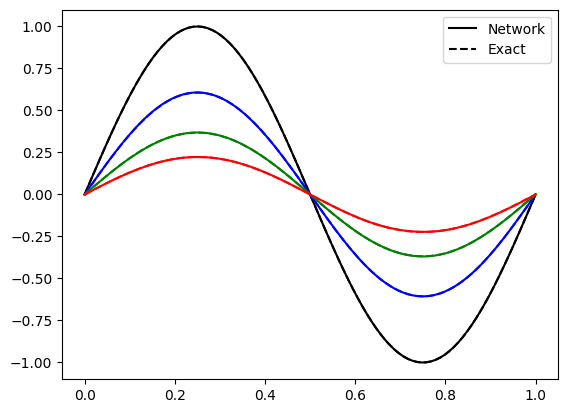

In [ ]:
# Plot the solution at half-second intervals
def plot_solution():
    x = np.reshape(np.linspace(0,1,100), (100,1))
    for i,c in enumerate(['k', 'b', 'g', 'r']):
        t = 0.5 * i * np.ones((100,1))
        u_network = solution_1d(t, x).numpy()
        u_exact = np.exp(-t)*np.sin(2*np.pi*x)
        plt.plot(x, u_network, c+'-')
        plt.plot(x, u_exact, c+'--')
    plt.legend(['Network', 'Exact'])

plot_solution()

## Define the loss function

Next let's define the loss function.  Recall that this will be the average residual squared error, evaluated on our set of collocation points, which will be passed into the loss function.

*Run the next cell to define the loss function.*

In [ ]:
def loss(t, x):
  pde_loss = tf.reduce_mean(
    tf.square(heat_equation_1d(t, x)))
  return pde_loss

## Train the network solution

With the network, solutio, PDE, and loss function defined, it is time to actually train the network on our PDE.  Training is done in the following steps:

1. Define an optimizer: this selects the optimization algorithm to use.  We will use the Adam algorithm which is a gradient descent method incorporating momentum and adaptive learning rate scaling.
2. Define our collocation points: here we will simply use a grid of 50x50 points on the $(t,x)$ domain.
3. For each epoch:
  1. Compute the current loss and it's gradient w.r.t. network parameters
  2. Apply the gradients with the optimizer to update the network parameters

That's it!

*Run the next cell train the network for 500 epochs.*

*After it's done, replot the solution above and see how it compares to the exact solution.*

Note that you can always run the following cell again to train for another 500 epochs.

In [ ]:
def grad(t, x):
  with tf.GradientTape() as tape:
    loss_value = loss(t, x)
  return loss_value, tape.gradient(loss_value, network.trainable_variables)

def train(num_epochs=500):
  optimizer = K.optimizers.Adam(learning_rate=0.01)

  t, x = np.meshgrid(np.linspace(0,2,50), np.linspace(0,1,50))
  t = tf.convert_to_tensor(np.reshape(t, (-1,1)))
  x = tf.convert_to_tensor(np.reshape(x, (-1,1)))

  for epoch in range(num_epochs):
    loss_value, grads = grad(t, x)
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
    if epoch % 100 == 0:
      print(f'{epoch}: loss = {loss_value}')

train()

0: loss = 0.0002961220158554128
100: loss = 0.00032934750715178255
200: loss = 0.00018784676267526304
300: loss = 0.0001252395738617735
400: loss = 8.848838923597826e-05
